# **Fake News Detection**

# **Project Description**



# **1. Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplcyberpunk
import warnings
import re
import nltk
import optuna

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

from ydata_profiling import ProfileReport
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec


nltk.download('punkt')
nltk.download('wordnet')
#plt.style.use("cyberpunk")

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

[nltk_data] Downloading package punkt to /Users/przemek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/przemek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
wel_fake = pd.read_csv('data/WELFake_Dataset.csv', index_col = 0)
fake_news_net = pd.read_csv('data/FakeNewsNet.csv', index_col=False)
true = pd.read_csv('data/true.csv', index_col=False)
fake = pd.read_csv('data/fake.csv', index_col=False)

# **2. Data analysis**

In [3]:
def balance_plot(df, label, plot_name):
    df.groupby(label)[label].count().plot(kind='pie', autopct='%1.1f%%', title=plot_name)

In [4]:
stopwords = set(STOPWORDS)
def word_cloud_plot(df, groupby, agg_column):
    wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df.groupby(groupby)[agg_column].sum()[0])
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## **2.1 WEL Fake dataset**

In [5]:
wel_fake

title  \
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                    NaN   
2      UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3      Bobby Jindal, raised Hindu, uses story of Chri...   
4      SATAN 2: Russia unvelis an image of its terrif...   
...                                                  ...   
72129  Russians steal research on Trump in hack of U....   
72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132  Trump tussle gives unpopular Mexican leader mu...   
72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Barack Obama Membe...      1  
1         Did they post their votes for Hillary already?      1  
2       Now, most of the demonstrators gathered last ...      1  
3      A dozen politically active pastors came here f...      0  
4      The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
...                                                  ...    ...  
72129  WASHINGTON (Reuters) - Hackers believed to be ...      0  
72130  You know, because in fantasyland Republicans n...      1  
72131  Migrants Refuse To Leave Train At Refugee Camp...      0  
72132  MEXICO CITY (Reuters) - Donald Trump’s combati...      0  
72133  Goldman Sachs Endorses Hillary Clinton For Pre...      1  

[72134 rows x 3 columns]

In [6]:
#ProfileReport(wel_fake, title='WELFake').to_file('WELFake.html')

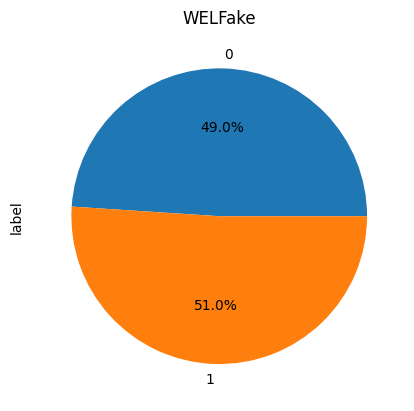

In [7]:
wel_fake.dropna(inplace=True)
wel_fake.reset_index(drop=True, inplace=True)
balance_plot(wel_fake, 'label', 'WELFake')

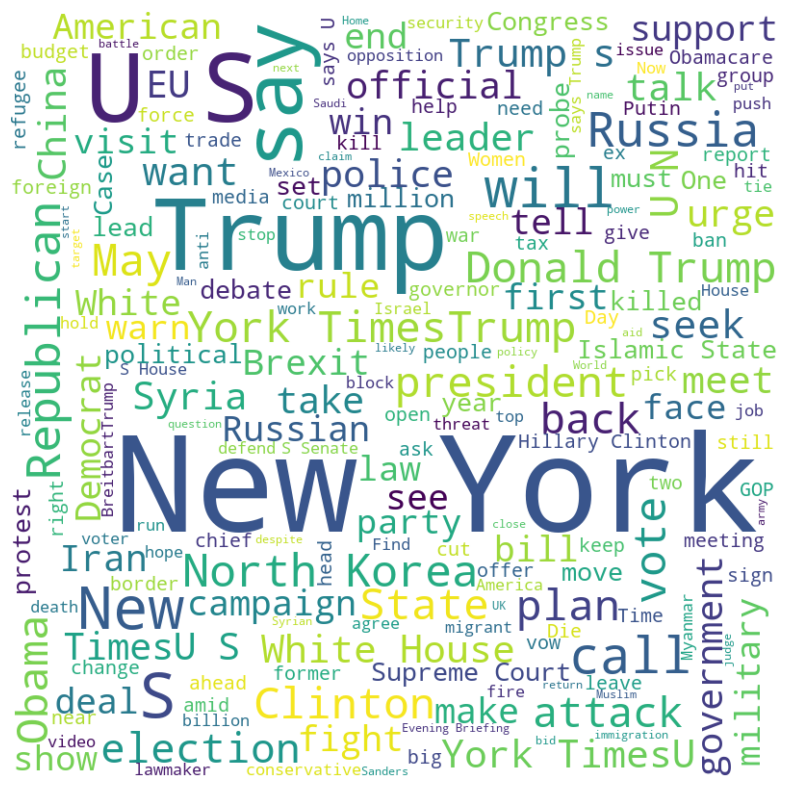

In [8]:
word_cloud_plot(wel_fake,'label', 'title')

## **2.2 Fake news net dataset**

In [9]:
fake_news_net

title  \
0      Kandi Burruss Explodes Over Rape Accusation on...   
1      People's Choice Awards 2018: The best red carp...   
2      Sophia Bush Sends Sweet Birthday Message to 'O...   
3      Colombian singer Maluma sparks rumours of inap...   
4      Gossip Girl 10 Years Later: How Upper East Sid...   
...                                                  ...   
23191  Pippa Middleton wedding: In case you missed it...   
23192  Zayn Malik & Gigi Hadid’s Shocking Split: Why ...   
23193  Jessica Chastain Recalls the Moment Her Mother...   
23194  Tristan Thompson Feels "Dumped" After Khloé Ka...   
23195  Kelly Clarkson Performs a Medley of Kendrick L...   

                                                news_url  \
0      http://toofab.com/2017/05/08/real-housewives-a...   
1      https://www.today.com/style/see-people-s-choic...   
2      https://www.etonline.com/news/220806_sophia_bu...   
3      https://www.dailymail.co.uk/news/article-33655...   
4      https://www.zerchoo.com/entertainment/gossip-g...   
...                                                  ...   
23191  https://www.express.co.uk/news/royal/807049/pi...   
23192  hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...   
23193  http://www.justjared.com/2018/01/17/jessica-ch...   
23194  www.intouchweekly.com/posts/tristan-thompson-f...   
23195  https://www.billboard.com/articles/news/bbma/8...   

               source_domain  tweet_num  real  
0                 toofab.com         42     1  
1              www.today.com          0     1  
2           www.etonline.com         63     1  
3        www.dailymail.co.uk         20     1  
4            www.zerchoo.com         38     1  
...                      ...        ...   ...  
23191      www.express.co.uk         52     1  
23192      hollywoodlife.com          7     0  
23193      www.justjared.com         26     1  
23194  www.intouchweekly.com         24     0  
23195      www.billboard.com         85     1  

[23196 rows x 5 columns]

In [10]:
#ProfileReport(fake_news_net, title='FakeNewsNet').to_file('FakeNewsNet.html')

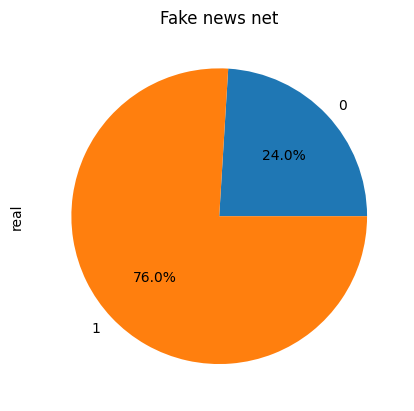

In [11]:
fake_news_net.dropna(inplace=True)
balance_plot(fake_news_net, 'real', 'Fake news net')

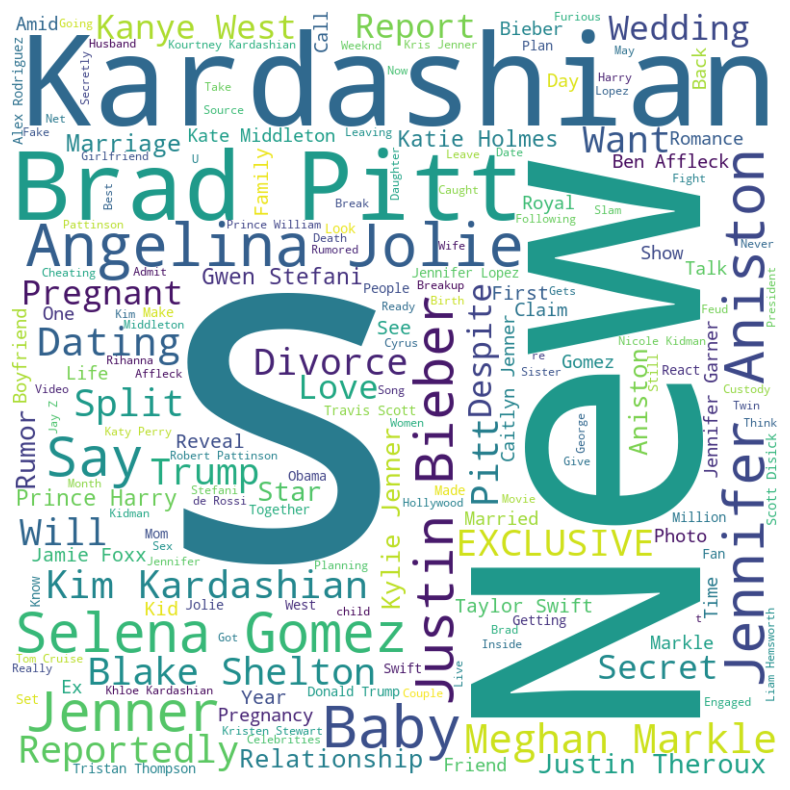

In [12]:
word_cloud_plot(fake_news_net,'real', 'title')

## **2.3 Fake and True dataset**

In [13]:
fake['label'] = 0

true['label'] = 1

In [14]:
fake_true = pd.concat([fake, true]).reset_index(drop=True)

In [15]:
#ProfileReport(fake_true, title='FakeTrue').to_file('FakeTrue.html')

In [16]:
fake_true

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       News   
3      On Christmas day, Donald Trump announced that ...       News   
4      Pope Francis used his annual Christmas Day mes...       News   
...                                                  ...        ...   
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44894  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44895  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                    date  label  
0      December 31, 2017      0  
1      December 31, 2017      0  
2      December 30, 2017      0  
3      December 29, 2017      0  
4      December 25, 2017      0  
...                  ...    ...  
44893   August 22, 2017       1  
44894   August 22, 2017       1  
44895   August 22, 2017       1  
44896   August 22, 2017       1  
44897   August 22, 2017       1  

[44898 rows x 5 columns]

In [17]:
fake_true.groupby(['subject', 'label']).count()

title   text   date
subject         label                     
Government News 0       1570   1570   1570
Middle-east     0        778    778    778
News            0       9050   9050   9050
US_News         0        783    783    783
left-news       0       4459   4459   4459
politics        0       6841   6841   6841
politicsNews    1      11272  11272  11272
worldnews       1      10145  10145  10145

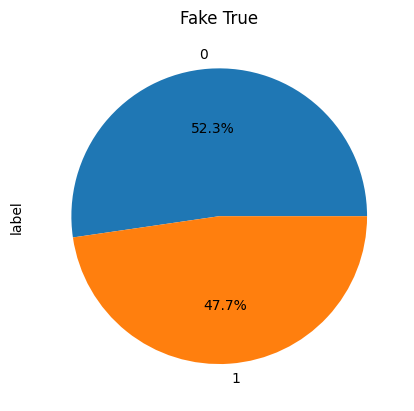

In [18]:
fake_true.dropna(inplace=True)
balance_plot(fake_true,'label', 'Fake True')

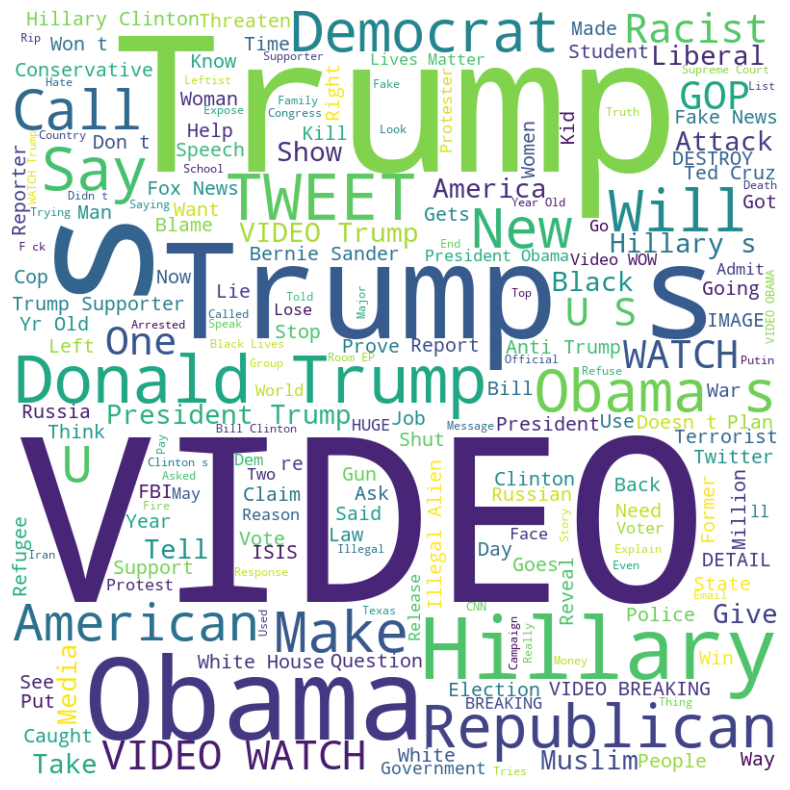

In [19]:
word_cloud_plot(fake_true,'label', 'title')

# **3. Data preprocessing**

In [20]:
#remove special characters and digits
def no_tags(text): 
    return re.sub(r'[^a-zA-Z\s]','ok',text)

In [21]:
def lower_case(text):
    text = [x.lower() for x in text]
    return text

In [22]:
def remove_multiple_spaces(text):
    text = [x.replace(" ", '') for x in text]
    return text

In [23]:
def tokenize_text(text):
    return nltk.word_tokenize(text)

In [24]:
stop_words = set(STOPWORDS)
stop_words.difference_update(set(['http', 'www']))
def cut_stop_words(text):
        filtered_words = [word for word in text if word not in stop_words]
        return filtered_words

In [25]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemantize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in text]
    return lemmatized_words

In [26]:
def preprocessing_df(df, col_name, new_col):
    df[col_name] = df[col_name].apply(no_tags) #remove special characters and digits
    df[new_col] = df[col_name].apply(tokenize_text)
    df[new_col] = df[new_col].apply(lower_case)
    df[new_col] = df[new_col].apply(cut_stop_words)
    df[new_col] = df[new_col].apply(lemantize_text)
    return df

In [27]:
def preprocessing_txt(text):
    text = no_tags(text) #remove special characters and digits
    text = tokenize_text(text)
    text = lower_case(text)
    text = cut_stop_words(text)
    text = lemantize_text(text)
    #text = remove_multiple_spaces(text)
    return text

## **3.1 WEL Fake preprocessing**

In [28]:
wel_fake

title  \
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1      UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
2      Bobby Jindal, raised Hindu, uses story of Chri...   
3      SATAN 2: Russia unvelis an image of its terrif...   
4      About Time! Christian Group Sues Amazon and SP...   
...                                                  ...   
71532  Russians steal research on Trump in hack of U....   
71533   WATCH: Giuliani Demands That Democrats Apolog...   
71534  Migrants Refuse To Leave Train At Refugee Camp...   
71535  Trump tussle gives unpopular Mexican leader mu...   
71536  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Barack Obama Membe...      1  
1       Now, most of the demonstrators gathered last ...      1  
2      A dozen politically active pastors came here f...      0  
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
4      All we can say on this one is it s about time ...      1  
...                                                  ...    ...  
71532  WASHINGTON (Reuters) - Hackers believed to be ...      0  
71533  You know, because in fantasyland Republicans n...      1  
71534  Migrants Refuse To Leave Train At Refugee Camp...      0  
71535  MEXICO CITY (Reuters) - Donald Trump’s combati...      0  
71536  Goldman Sachs Endorses Hillary Clinton For Pre...      1  

[71537 rows x 3 columns]

### **3.1.1 Split Data**

In [29]:
X = wel_fake['title']
y = wel_fake['label']
X_train_wel, X_test_wel, y_train_wel, y_test_wel = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_wel, X_val_wel, y_train_wel, y_val_wel = train_test_split(X_train_wel, y_train_wel, test_size=0.2, random_state=42)

In [30]:
y_train_wel.value_counts(normalize=True) #imbalance check

1    0.510408
0    0.489592
Name: label, dtype: float64

### **3.1.2 Bag of Words**

In [31]:
transformer = CountVectorizer(analyzer = preprocessing_txt)
bow_train_wel = transformer.fit_transform(X_train_wel)
bow_test_wel = transformer.transform(X_test_wel)
bow_val_wel = transformer.transform(X_val_wel)

In [32]:
bow_wel = bow_train_wel.toarray()

df = pd.DataFrame(data=bow_wel,columns = transformer.get_feature_names_out())

df[df['zurich'] == 1] #example

aa  aaa  aapok  aar  aardvark  aardvarkok  aaron  aarp  ab  abadi  \
6089   0    0      0    0         0           0      0     0   0      0   

      abandon  abandona  abbas  abbasok  abbott  abbottok  abby  abc  abcok  \
6089        0         0      0        0       0         0     0    0      0   

      abcokok  abcoks  abcokwapo  abcokwashington  abd  abdel  abdicate  \
6089        0       0          0                0    0      0         0   

      abdication  abdicationok  abdoknin  abduct  abduction  abdul  abdullah  \
6089           0             0         0       0          0      0         0   

      abdulokjabbarok  abe  abed  abedin  abedinok  abedinoks  abedioks  \
6089                0    0     0       0         0          0         0   

      abeok  abeoks  abeoktrump  abercrombie  abet  abgelegenen  abgesprochen  \
6089      0       0           0            0     0            0             0   

      abhorrent  abide  abilitiesok  ability  able  ableokbodied  abnormal  \
6089          0      0            0        0     0             0         0   

      abnormalitiesokoknever  aboard  aboardok  abokokin  abolish  abolition  \
6089                       0       0         0         0        0          0   

      abort  abortedok  abortion  abortionok  abortionokok  abortionokokokif  \
6089      0          0         0           0             0                 0   

      abortionokrelated  abortions  abound  aboutok  aboutokface  \
6089                  0          0       0        0            0   

      aboutokfaceok  aboutokvoting  abraham  abramoviok  abrams  abramsok  \
6089              0              0        0           0       0         0   

      abran  abridge  abroad  abroadok  abroadokvillage  abrogation  abrupt  \
6089      0        0       0         0                0           0       0   

      abruptly  absence  absenceok  absenceokoksheok  absent  absentee  \
6089         0        0          0                 0       0         0   

      absentia  absentiaok  absichtlich  absokok  absolute  absolutely  \
6089         0           0            0        0         0           0   

      absoluter  absorb  abstain  abstentionok  abstinence  abstinenceokonly  \
6089          0       0        0             0           0                 0   

      absurd  absurdistanokok  absurdity  absurdly  absurdok  absurdokok  abu  \
6089       0                0          0         0         0           0    0   

      abuse  abuseok  abuseokmiddle  abuser  abuserokinokchief  abuserokyou  \
6089      0        0              0       0                  0            0   

      abusers  abusesok  abusive  abusiveok  aby  aca  acaba  academic  \
6089        0         0        0          0    0    0      0         0   

      academics  academy  academyok  acaok  accelerate  acceleratesok  accent  \
6089          0        0          0      0           0              0       0   

      accentok  accept  acceptable  acceptableok  acceptance  acceptedok  \
6089         0       0           0             0           0           0   

      acceptsokinvites  access  accession  accessok  accessory  accident  \
6089                 0       0          0         0          0         0   

      accidental  accidentally  accidentok  accidents  accidentsok  acclaim  \
6089           0             0           0          0            0        0   

      accolade  accommodate  accommodation  accompany  accomplice  \
6089         0            0              0          0           0   

      accomplices  accomplicesok  accomplish  accomplishedok  \
6089            0              0           0               0   

      accomplishmentok  accomplishments  accomplishmentsokitoks  acconciok  \
6089                 0                0                       0          0   

      accord  accordion  accordok  accordsok  accost  account  accountability  \
6089       0          0         0          0       0        0               

### **3.1.3 Bag of Word 2 Vec**

In [33]:
sentence = preprocessing_df(wel_fake, 'title', 'title')

w2v_model = Word2Vec(sentence, min_count=1, vector_size = 300) 

word_list = list(w2v_model.wv.key_to_index)

w2v_model.wv.most_similar('poland')

KeyError: "Key 'poland' not present in vocabulary"

In [ ]:
word_list

In [ ]:
def w2v_train_test_prepatarion(data):
    X_train_vec = [] 
    for sentence in data:
        sentence_vec = []
        for word in sentence.split():
            if word in w2v_model.wv.key_to_index:
                sentence_vec.append(w2v_model.wv[word])
        X_train_vec.append(np.mean(sentence_vec, axis=0))
    return X_train_vec

In [ ]:
X_train_w2v_wel = w2v_train_test_prepatarion(X_train_wel)
X_test_w2v_wel = w2v_train_test_prepatarion(X_test_wel)
X_val_w2v_wel = w2v_train_test_prepatarion(X_val_wel)

In [ ]:
X_train_w2v_wel = [x for x in X_train_w2v_wel if str(x) != 'nan']

In [ ]:
X_train_wel

## **3.2 Fake News Net preprocessing**

In [ ]:
fake_news_net.drop(['source_domain', 'tweet_num'], axis=1, inplace=True)

In [ ]:
#Duplicate imbalanced data
fake = fake_news_net[fake_news_net['real'] == 0]
fake_news_net = pd.concat([fake_news_net, fake])
fake_news_net = pd.concat([fake_news_net, fake])

In [ ]:
balance_plot(fake_news_net, 'real', 'Balance check after oversampling')

### **3.2.1 Split data**

In [ ]:
X = fake_news_net['title']
y = fake_news_net['real']
X_train_net, X_test_net, y_train_net, y_test_net = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_net, X_val_net, y_train_net, y_val_net = train_test_split(X_train_net, y_train_net, test_size=0.2, random_state=42)

In [ ]:
y_train_net.value_counts(normalize=True) #imbalance check

### 3.2.2 Bag of Words

In [ ]:
transformer = CountVectorizer(analyzer = preprocessing_txt)
bow_train_net = transformer.fit_transform(X_train_net)
bow_test_net = transformer.transform(X_test_net)
bow_val_net = transformer.transform(X_val_net)

In [ ]:
bow = bow_train_net.toarray()

df = pd.DataFrame(data=bow,columns = transformer.get_feature_names_out())

df[df['abdul'] == 1] #example

### **3.2.3 Bag of Word 2 Vec**

In [ ]:
fake_news_net['news_url'] = fake_news_net['news_url'].str.replace('/', ' ')
fake_news_net = preprocessing_df(fake_news_net, 'news_url', 'news_url')

In [ ]:
fake_news_net = preprocessing_df(fake_news_net, 'title', 'title')
#Concatenate columns due to https pages are real
fake_news_net['title'] = fake_news_net['title'] + fake_news_net['news_url']

In [ ]:
w2v_model = Word2Vec(fake_news_net['title'], min_count=1, vector_size = 300)

word_list = list(w2v_model.wv.key_to_index)

w2v_model.wv.most_similar('poland')

In [ ]:
X_train_w2v_net = w2v_train_test_prepatarion(X_train_net)
X_test_w2v_net = w2v_train_test_prepatarion(X_test_net)
X_val_w2v_net = w2v_train_test_prepatarion(X_val_net)

## **3.3 Fake and True preprocessing**

In [ ]:
fake_true.duplicated().sum()

In [ ]:
fake_true.drop_duplicates(inplace=True)

In [ ]:
fake_true

### **3.3.1 Split data**

In [ ]:
X = fake_true['title']
y = fake_true['label']
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_ft, X_val_ft, y_train_ft, y_val_ft = train_test_split(X_train_ft, y_train_ft, test_size=0.2, random_state=42)

In [ ]:
y_train_ft.value_counts(normalize=True) #imbalance check

### **3.3.2 Bag of words**

In [ ]:
transformer = CountVectorizer(analyzer = preprocessing_txt)
bow_train_ft = transformer.fit_transform(X_train_ft)
bow_test_ft = transformer.transform(X_test_ft)
bow_val_ft = transformer.transform(X_val_ft)

In [ ]:
bow = bow_train_ft.toarray()

df = pd.DataFrame(data=bow,columns = transformer.get_feature_names_out())

df[df['abdicate'] == 1] #example

### **3.3.3 Bag of Word 2 Vec**

In [ ]:
fake_true = preprocessing_df(fake_true, 'title', 'title')

In [ ]:
w2v_model = Word2Vec(fake_true['title'], min_count=1, vector_size = 300)

word_list = list(w2v_model.wv.key_to_index)

w2v_model.wv.most_similar('poland')

In [ ]:
X_train_w2v_ft = w2v_train_test_prepatarion(X_train_ft)
X_test_w2v_ft = w2v_train_test_prepatarion(X_test_ft)
X_val_w2v_ft = w2v_train_test_prepatarion(X_val_ft)

## 4. Models

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data)
        self.labels = torch.tensor(labels)
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index):
        return self.data, self.labels

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        data, target = batch_data[0].to(device), batch_data[1].to(device)
        data = data.reshape(-1, len(batch_data))
        target = target.reshape(-1, 1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def predict(input_data):
    model.eval()
    input_tensor = torch.tensor(input_data, dtype=torch.float)

    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.sigmoid(output)

    prediction = prediction.numpy()

    return prediction

## 4.1 WELFake

In [ ]:
len(y_train_wel)

In [ ]:
bow_train_wel.shape[0]

In [ ]:
# Tworzenie obiektu klasy MyDataset
# y_train_wel.reset_index(drop=True, inplace= True)
# X_train_w2v_wel.reset_index(drop=True, inplace= True)
# X_train = []
# y_train = []
# for tensor in X_train_wel:
#     X_train.append(tensor)
    
# for tensor in y_train_wel:
#     y_train.append(tensor)
    
train_set = MyDataset(bow_wel, y_train_wel.values)

# Tworzenie obiektu DataLoader
batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
input_dim = 300 # w2v_model parameter vector_size = 300
output_dim = 1
model = LogisticRegression(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
y_train_wel.shape

In [ ]:
bow_wel.shape

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

In [ ]:
train(model, train_loader, criterion, optimizer, device)

## 4.2 Fake_news_net

## 4.3 Fake True